In [1]:
import pandas as pd
from plotnine import *
import plotnine
import sklearn.metrics

In [18]:
def compute_feature_aurocs(df):
    multipliers = dict()
    for feature in df.columns[7:]:
        if feature[:2] == 'p_':
            multipliers[feature] = -1
        else:
            multipliers[feature] = 1
            
    no_train_df = df.query('train == 0')
    try:
        records = (
            (feature,
            sklearn.metrics.roc_auc_score(df['train'], multiplier * df[feature]),
            sklearn.metrics.roc_auc_score(no_train_df['test_recon'], multiplier * no_train_df[feature]),
            sklearn.metrics.roc_auc_score(no_train_df['test_new'], multiplier * no_train_df[feature]))
            for feature, multiplier in multipliers.items()
        )
    except ValueError:
        print(network, feature)
    return pd.DataFrame.from_records(records, columns=['feature', 'train_auc', 'reconstruction_auc', 
                                                       'systematic_auc'])

In [3]:
lines = pd.DataFrame.from_dict({'network': ['train', 'test_recon', 'test_new'],
                                'slope': [1, 1, 1], 'intercept': [0, 0, 0]})

# PPI network

In [17]:
ppi_df = pd.read_csv('../data/4.data/ppi.tsv.xz', sep='\t', compression='xz')

ppi_df.head(2)

,name_a,name_b,id_a,id_b,train,test_recon,test_new,edge_prior,rwr,mean_rwr,p_rwr,jaccard,mean_jaccard,p_jaccard
0,A0A087WT00,A0A087WT00,0,0,0,0,0,0.0,0.251604,0.251248,0.038,1.0,1.000000,1.0
1,A0A087WT00,A0A0B4J1W7,0,1,0,0,0,0.0,0.000016,0.000015,0.088,0.0,0.001492,1.0


In [18]:
ppi_roc_df = ppi_df.query('train == 0')

In [19]:
ppi_info = compute_feature_aurocs(ppi_roc_df)

ppi_info

,feature,reconstruction_auc,systematic_auc
0,edge_prior,0.779769,0.477629
1,rwr,0.890664,0.543606
2,mean_rwr,0.793196,0.506424
3,p_rwr,0.768321,0.557323
4,jaccard,0.882940,0.529506
5,mean_jaccard,0.791572,0.510351
6,p_jaccard,0.859260,0.502305


In [39]:
feature_to_info = {'edge_prior': 'no edge info', 'mean_rwr': 'no edge info', 
                   'rwr': 'feature', 'p_rwr': 'corrected feature',
                   'jaccard': 'feature', 'mean_jaccard': 'no edge info',
                   'p_jaccard': 'corrected feature'}
feature_to_class = {'p_rwr': 'RWR', 'mean_rwr': 'RWR', 'rwr': 'RWR', 'edge_prior': 'edge_prior',
                    'jaccard': 'Jaccard', 'mean_jaccard': 'Jaccard', 'p_jaccard': 'Jaccard',}

ppi_roc = pd.DataFrame()
for feature in ppi_df.columns[7:]:
    m = -1 if 'p_' in feature else 1
    for network in ppi_df.columns[4:7]:
        fpr, tpr, _ = sklearn.metrics.roc_curve(ppi_df[network], m * ppi_df[feature])
        df = (
            pd.DataFrame()
            .assign(
                fpr=fpr,
                tpr=tpr,
                feature=feature,
                feature_class=feature_to_class[feature],
                network=network,
                info=feature_to_info[feature]
            )
        )
        ppi_roc = pd.concat([ppi_roc, df])

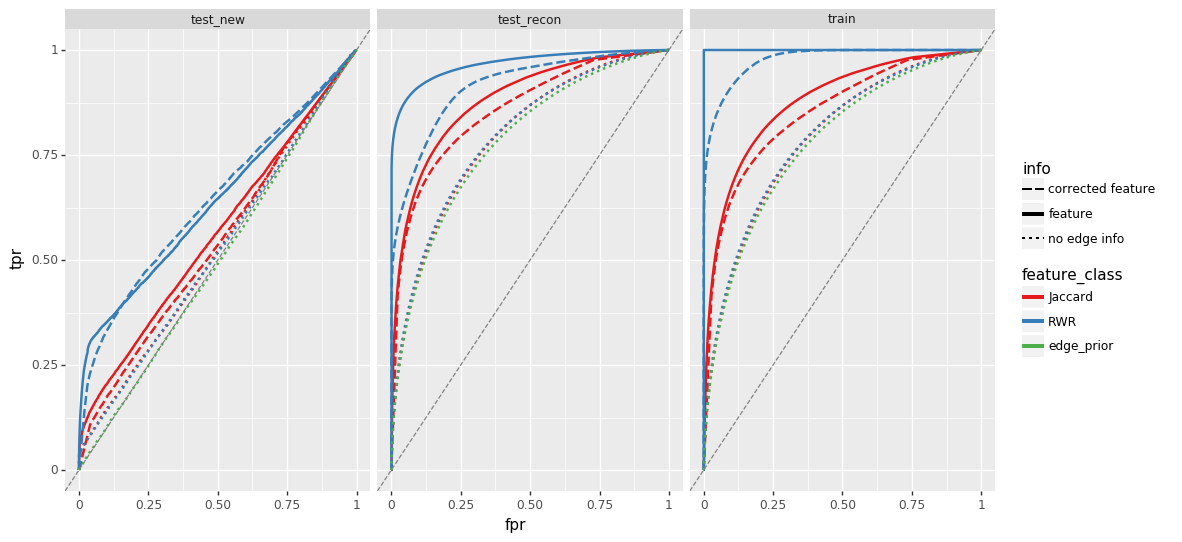

<ggplot: (8741520204373)>

In [42]:
plotnine.options.figure_size = (12, 6)

g = (
    ggplot(ppi_roc, aes(x='fpr', y='tpr', color='feature_class', linetype='info'))
    + geom_path(size=1)
    + facet_wrap('network')
    + geom_abline(lines, aes(slope='slope', intercept='intercept'), linetype='dashed', color='grey')
    + scale_linetype_manual(values=['dashed', 'solid', 'dotted'])
    + scale_color_brewer(type='qual', palette=6)
)
g

# BioRxiv network

# TODO: Somehow only one class present here as well.

In [12]:
biorxiv_df = pd.read_csv('../data/4.data/biorxiv.tsv.xz', sep='\t', compression='xz')
biorxiv_df.head(2)

,name_a,name_b,id_a,id_b,train,test_recon,test_new,edge_prior,rwr,mean_rwr,p_rwr,jaccard,mean_jaccard,p_jaccard
0,- The US-Venezuela Collaborative Research Group,Aaron A Best,0,1,0,0,0,0.0,1.897272e-07,0.000574,1.0,0.0,0.020004,1.0
1,- The US-Venezuela Collaborative Research Group,Aaron E Darling,0,2,0,0,0,0.0,9.138554e-06,0.000416,1.0,0.0,0.015634,1.0


In [14]:
biorxiv_df[['train','test_recon', 'test_new']].sum()

train         28584
test_recon    24576
test_new      28584
dtype: int64

In [23]:
biorxiv_df.query('train == 0 and test_new == 1')

,name_a,name_b,id_a,id_b,train,test_recon,test_new,edge_prior,rwr,mean_rwr,p_rwr,jaccard,mean_jaccard,p_jaccard


In [19]:
compute_feature_aurocs(biorxiv_df)

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

# TFTG network

In [24]:
tftg_df = (
    pd.read_csv('../data/4.data/tftg.tsv.xz', sep='\t', compression='xz')
    .assign(negative_p=lambda df: -df['p_inf'])
)
tftg_df.head(2)

,name_a,name_b,id_a,id_b,train,test_recon,test_new,edge_prior,inf,mean_inf,p_inf,negative_p
0,AHR,AHR,0,0,0,0,0,0.0,0.0,0.0,1.0,-1.0
1,AHR,AR,0,1,0,0,0,0.0,0.0,0.0,1.0,-1.0


In [25]:
compute_feature_aurocs(tftg_df)

,feature,train_auc,reconstruction_auc,systematic_auc
0,edge_prior,0.845252,0.823425,0.590710
1,inf,0.604596,0.605282,0.513710
2,mean_inf,0.702877,0.687681,0.554804
3,p_inf,0.602835,0.600929,0.513142
4,negative_p,0.602835,0.600929,0.513142


In [29]:
feature_to_info = {'edge_prior': 'no edge info', 'mean_inf': 'no edge info', 
                   'inf': 'feature', 'negative_p': 'corrected feature'}
feature_to_class = {'edge_prior': 'edge_prior', 'inf': 'Inference score', 'mean_inf': 'Inference score',
                    'p_inf': 'Inference score', 'negative_p': 'Inference score'}

tftg_roc = pd.DataFrame()
for feature in ['edge_prior', 'inf', 'mean_inf', 'negative_p']:
    for network in ['train', 'test_recon', 'test_new']:
        fpr, tpr, _ = sklearn.metrics.roc_curve(tftg_df[network], tftg_df[feature])
        feature_df = (
            pd.DataFrame()
            .assign(
                fpr=fpr,
                tpr=tpr,
                feature=feature,
                network=network,
                info=feature_to_info[feature],
                feature_class=feature_to_class[feature]
            )
        )
        tftg_roc = pd.concat([tftg_roc, feature_df])

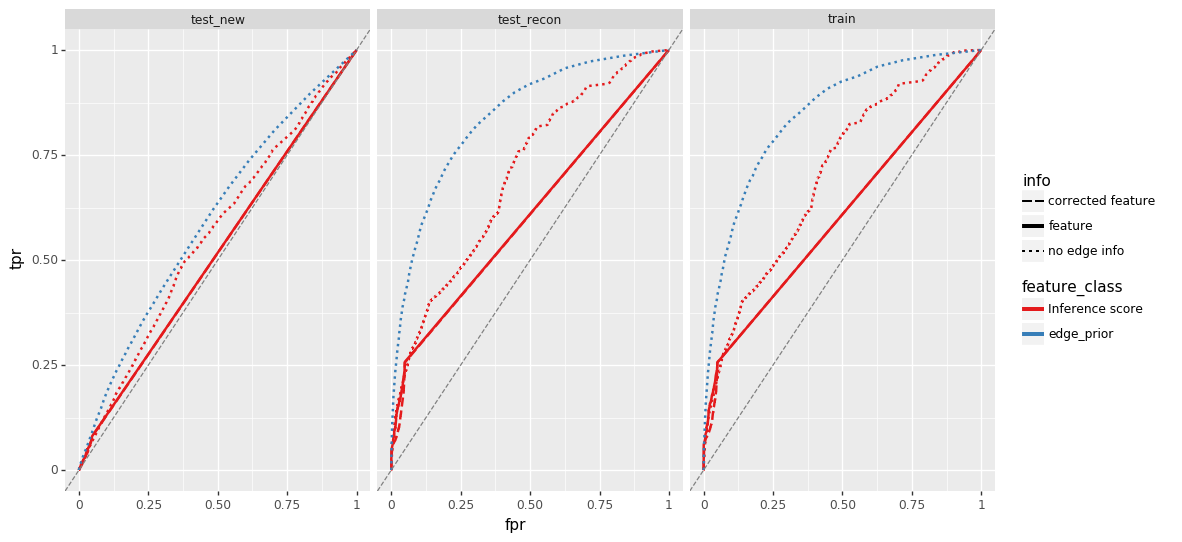

<ggplot: (8790579689743)>

In [31]:
plotnine.options.figure_size = (12, 6)

g = (
    ggplot(tftg_roc, aes(x='fpr', y='tpr', color='feature_class', linetype='info'))
    + geom_path(size=1)
    + facet_wrap('network')
    + geom_abline(lines, aes(slope='slope', intercept='intercept'), linetype='dashed', color='grey')
    + scale_linetype_manual(values=['dashed', 'solid', 'dotted'])
    + scale_color_brewer(type='qual', palette=6)
)
g